# Параеметры ноутбучика

In [1]:
batch_size = 32
num_workers = 0

# Распаковка файлов

In [93]:
!rm -Rf ./Goznak_ML_Tasks/

In [94]:
%%bash
unzip Goznak_ML_Tasks.zip

Archive:  Goznak_ML_Tasks.zip
   creating: Goznak_ML_Tasks/
 extracting: Goznak_ML_Tasks/Tasks description-3.docx  
 extracting: Goznak_ML_Tasks/explore_data.rar  
 extracting: Goznak_ML_Tasks/train.part1.rar  
 extracting: Goznak_ML_Tasks/train.part2.rar  
 extracting: Goznak_ML_Tasks/val.rar  


In [95]:
%%bash
cd Goznak_ML_Tasks
unrar x train.part2.rar 1>/dev/null
mv train train_
mv ./train_/train train
rmdir train_
rm train.part1.rar train.part2.rar

In [96]:
%%bash
cd Goznak_ML_Tasks
unrar x val.rar 1>/dev/null
mv val val_
mv ./val_/val ./ 
rmdir val_
rm val.rar

In [97]:
%%bash 
cd Goznak_ML_Tasks/
unrar x explore_data.rar 1>/dev/null

In [98]:
!du -hcxs ./Goznak_ML_Tasks/

3.3G	./Goznak_ML_Tasks/
3.3G	total



# Датасет

In [2]:
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
class DenoiseDataset(Dataset):
    def __init__(self, root):
        self.clean = {
            npy.name: npy
            for subdir in (root/'clean').iterdir()
            for npy in subdir.iterdir()
        }
        self.noisy = {
            npy.name: npy
            for subdir in (root/'noisy').iterdir()
            for npy in subdir.iterdir()
        }
        self.names = sorted(self.clean.keys())
        assert self.names == sorted(self.noisy.keys())
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, i):
        name = self.names[i]
        res = {
            'clean': np.load(self.clean[name]),
            'noisy': np.load(self.noisy[name]),
        }
        res['mask'] = np.ones_like(res['clean'], dtype=np.uint8)
        return res
        
train = DenoiseDataset(Path('Goznak_ML_Tasks/train'))
val = DenoiseDataset(Path('Goznak_ML_Tasks/val'))
len(train.names), len(val.names)

(12000, 2000)

Text(0.5, 1.0, 'length distribution')

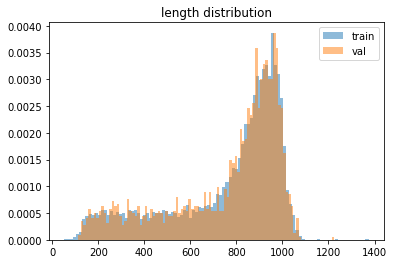

In [4]:
plt.hist([len(item['clean']) for item in train], bins=100, alpha=0.5, label='train', density=True);
plt.hist([len(item['clean']) for item in val], bins=100, alpha=0.5, label='val', density=True);
plt.legend();
plt.title('length distribution')

In [5]:
train_set = set([item.split('_')[0] for item in train.names])
val_set = set([item.split('_')[0] for item in val.names])
len(train_set), len(val_set), len(train_set.intersection(val_set))

(799, 150, 0)

In [6]:
def rec_collate(lst):
    return {
        key: pad_sequence(
            [torch.Tensor(elem[key]) for elem in lst],
            batch_first=True
        )
        for key in ['clean', 'noisy', 'mask']
    }
        

train_loader = DataLoader(
    train, 
    batch_size=batch_size, 
    collate_fn=rec_collate,
    num_workers=num_workers
)
val_loader = DataLoader(
    val, 
    batch_size=batch_size, 
    collate_fn=rec_collate
)

for batch in train_loader:
    break

# Модель

In [55]:
import torch
from torch import nn

torch.Size([32, 1041, 80])

In [75]:
def masked_mean(vals, mask):
    batch_size = vals.shape[0]
    vals = vals.reshape(batch_size, -1)
    mask = mask.reshape(batch_size, -1)
    return (vals * mask).sum(dim=1) / mask.sum(dim=1)


def validate(model, loader):
    model.eval()
    torch.set_grad_enabled(False)
    squared_errors = []
    for batch in tqdm(loader):
        batch_size = len(batch['clean'])
        model_out = model(batch)
        squared_error = (model_out - batch['clean'])**2
        squared_errors.extend(
            masked_mean(squared_error, batch['mask'])\
            .cpu().numpy().tolist()
        )
    squared_errors = np.array(squared_errors)

    return {
        'mse': np.array(squared_errors).mean()
    }
    return errors.mean()
    
validate(model, train_loader)

  0%|          | 0/375 [00:00<?, ?it/s]

{'mse': 0.2602274516063432}

# Baselines

In [76]:
class Copy(nn.Module):
    def forward(self, batch):
        return batch['noisy']

validate(Copy(), val_loader)

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.13281262585916556}

# Обучение сети

In [79]:
from torch import optim

In [70]:
class Model(nn.Module):
    def __init__(self, n_hidden=100):
        super().__init__()
        self.net = nn.LSTM(
            input_size=80, 
            hidden_size=80,
            batch_first=True
        )
        
    def forward(self, batch):
        return self.net(batch['clean'])[0]
        
model = Model()
model(batch).shape

torch.Size([32, 1041, 80])

In [71]:
def train_loss(batch, model_out):
    error = (model_out - batch['clean'])**2
    return masked_mean(error, batch['mask']).mean()

In [84]:
model = Model()
opt = optim.Adam(model.parameters(), lr=0.01)
history = {'train': [], 'val': []}
for epoch in tqdm(range(10)):
    model.train()
    torch.set_grad_enabled(True)
    for batch in tqdm(train_loader, leave=False):
        opt.zero_grad()
        model_out = model(batch)
        loss = train_loss(batch, model_out)
        loss.backward()
        opt.step()
    history['train'].append(validate(model, train_loader))
    history['val'].append(validate(model, val_loader))
    print(history['train'][-1], history['val'][-1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.0081239699437477} {'mse': 0.007173855497967452}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.005342001063836505} {'mse': 0.0044822781671537085}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.004784455588669516} {'mse': 0.003968670826143352}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.004283453380495} {'mse': 0.003484113052138127}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.004248284895545415} {'mse': 0.003441904083621921}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.00417626455501401} {'mse': 0.0033742993197811303}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.00411299122745307} {'mse': 0.003314156557928072}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.004460455746428731} {'mse': 0.0036551482338400094}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.004196128217939986} {'mse': 0.0034162197029800156}


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'mse': 0.0038920214204141907} {'mse': 0.0031007455872313584}
